In [1]:
from glob import glob
import re

In [15]:
DATA_DIR = "../data/"

In [16]:
image_paths = glob(DATA_DIR + "*")

In [13]:
import cv2
import numpy as np
from copy import copy
from image import Image

PUPIL_THRESH_FACTOR = 2.0
IRIS_THRESH_FACTOR = 1.1


def preprocess_iris_image(image_path: str) -> np.ndarray:
    pass


def find_circle_nearest_center(binarized_image: Image, **kwargs) -> np.ndarray:
    """
    Use Hough Transform to find circles in the image and return the one
    closest to the image center.

    :param binarized_image: Binary BW image
    :param kwargs:          Arguments to be passed to cv2.HoughCircles

    :return: Coordinates and radius of the circle found with the smallest
             Euclidean distance to the image's center
    """
    image_center = np.array([binarized_image.width // 2,
                             binarized_image.height // 2])

    circles = cv2.HoughCircles(binarized_image.img,
                               method=cv2.HOUGH_GRADIENT, **kwargs)

    assert circles is not None, "No circles found"

    dist_from_centre = np.linalg.norm(circles[0, :, :2] - image_center, axis=1)

    return circles[0, np.argmin(dist_from_centre)]


def circle_iris_and_pupil(eye: Image):
    """
    :param eye_bw:
    """
    eye_bw = eye.to_bw()
    
    pupil = eye_bw.binarize(PUPIL_THRESH_FACTOR)
    pupil_only = pupil.close(np.ones((6, 6), np.uint8))

    pupil_center = find_circle_nearest_center(pupil_only,
                                              dp=1.0,
                                              minDist=200,
                                              param1=10,
                                              param2=15,
                                              minRadius=20,
                                              maxRadius=150)
    iris = eye_bw.enhance_contrast().binarize(IRIS_THRESH_FACTOR)
    iris_only = iris.close(np.ones((6, 6), np.uint8)) \
        .erode(np.ones((8, 8), np.uint8)) \
        .open(np.ones((5, 5), np.uint8))
    
    iris_center = find_circle_nearest_center(iris_only,
                                             dp=1.0,
                                             minDist=200,
                                             param1=10,
                                             param2=10,
                                             minRadius=150,
                                             maxRadius=300)

    # Draw the pupil and the iris
    circled = copy(eye)

    # Pupil
    circled = circled.draw_circle(*pupil_center)

    # Iris
    circled = circled.draw_circle(*iris_center)

    return circled


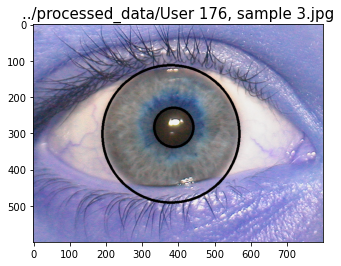

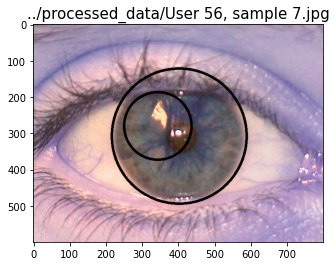

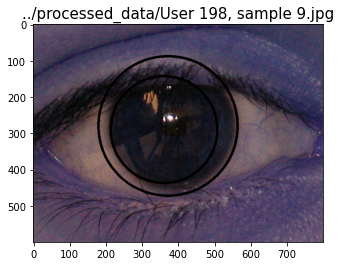

AssertionError: No circles found

In [28]:
filename_regex = r"(\d+)_(\d+)\.jpg"

for image_path in image_paths[:20]:
    # Extract user ID and the sample number from the filename
    image_filename = image_path.split("/")[-1]
    user_id, sample_id = re.match(filename_regex, image_filename).groups()
    iris = Image(image_path=image_path)
#     iris_bw = iris.to_bw()
#     iris_bw.show(title=f"User {user_id}, sample {sample_id}", cmap="gray")
    circle_iris_and_pupil(iris).show(f"../processed_data/User {user_id}, sample {sample_id}.jpg")


In [ ]:
img = Image(image_path='../data/176_3.jpg')

eyes = eye_cascade.detectMultiScale(img.to_bw().img, 1.3, 5)

img = img.img

for (x, y, w, h) in eyes:
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

Image(img).show()

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass


@dataclass
class Circle:
    center_x: int
    center_y: int
    radius: int

    def is_within(self, other) -> bool:
        """
        :param other: Another Circle instance
        :return: True is this circle is contained in another circle
        """
        this_center = np.array([self.center_x, self.center_y])
        other_center = np.array([other.center_x, other.center_y])
        center_dist = np.linalg.norm(this_center - other_center)
        return other.radius > (center_dist + self.radius)


class Image:
    def __init__(self, img: np.ndarray = None, image_path: str = None):
        self.img = img
        self.pupil = None
        self.iris = None

        if image_path is not None:
            self.read(image_path)
        else:
            if img is not None:
                self._update_shape()
            else:
                self.height = None
                self.width = None
                self.num_channels = None

    def _update_shape(self):
        self.height = self.img.shape[0]
        self.width = self.img.shape[1]
        if len(self.img.shape) == 3:
            self.num_channels = self.img.shape[2]
        else:
            self.num_channels = 1

    def read(self, input_image_path: str):
        self.img = cv2.imread(filename=input_image_path)
        self._update_shape()

    def save(self, output_image_path: str):
        assert self.img is not None, "Trying to write an empty binarized_image"
        cv2.imwrite(filename=output_image_path, img=self.img)

    def show(self, title=None, fontsize=15, cmap="gray"):
        plt.imshow(self.img, cmap=cmap)
        if title is not None:
            plt.title(title, fontsize=fontsize)
        plt.show()

    def binarize(self, threshold_factor: float):
        p = np.sum(self.img) / (self.height * self.width)
        p = p / threshold_factor

        # Use binary thresholding
        _, thresholded = cv2.threshold(self.img, p, np.max(self.img),
                                       cv2.THRESH_BINARY)

        return Image(thresholded)

    def erode(self, kernel, iterations=1):
        return Image(cv2.erode(self.img, kernel, iterations=iterations))

    def close(self, kernel):
        return Image(cv2.morphologyEx(self.img, cv2.MORPH_CLOSE, kernel))

    def open(self, kernel):
        return Image(cv2.morphologyEx(self.img, cv2.MORPH_OPEN, kernel))

    def to_bw(self):
        return Image(cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY))

    def draw_circle(self, x_coord, y_coord, radius, color=(0, 0, 0),
                    thickness=5):
        return Image(cv2.circle(self.img, (x_coord, y_coord), radius, color,
                                thickness=thickness))

    def enhance_contrast(self):
        assert self.num_channels == 1, \
            "Contrast enhancement only supported for BW images"
        return Image(cv2.equalizeHist(self.img))

    def stretch_histogram(self, min_val: int = 0, max_val: int = 255):
        assert 0 <= min_val < max_val, "Min must be between 0 and max"
        assert 0 < max_val <= 255, "Max must be between 0 and 255"
        assert self.num_channels == 1, \
            "Stretching histogram only supported for BW images"

        hist = cv2.calcHist(images=[self.img], channels=[0], mask=None,
                            histSize=[256], ranges=[0, 256])

        assert hist is not None

        while hist[min_val][0] <= 0:
            min_val += 1

        while hist[max_val][0] <= 0:
            max_val -= 1

        frac = 255 / (max_val - min_val)
        stretched_img = (self.img - min_val) * frac

        return Image(stretched_img)


In [ ]:
c

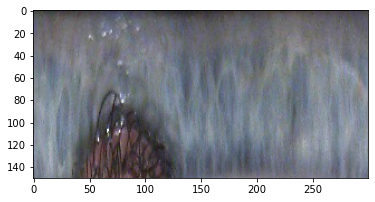

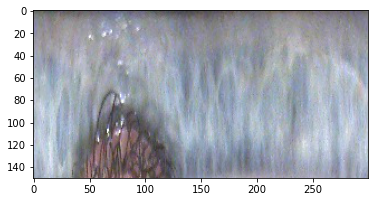

In [97]:
iris = Image(image_path="../normalized_data/105_0.jpg")
iris.img = cv2.cvtColor(iris.img, cv2.COLOR_BGR2RGB)
iris.show()
Image(cv2.convertScaleAbs(iris.img, alpha=1.2, beta=20)).show(cmap=None)

In [46]:
np.all(iris.img == iris.stretch_histogram().img)

False

In [25]:
class ImageProcessingError(Exception):
    pass


In [26]:
raise ImageProcessingError

ImageProcessingError: 

In [84]:
import shutil

In [70]:
circled = glob("../circled_images/*.jpg")
circled[:3]

['../circled_images/24_2.jpg',
 '../circled_images/239_4.jpg',
 '../circled_images/61_8.jpg']

In [74]:
user_stats = {}

for path in circled:
    image_filename = path.split("/")[-1]
    user_id, sample_id = re.match(filename_regex, image_filename).groups()
    user_stats[user_id] = user_stats.get(user_id, 0) + 1

In [83]:
wanted_users = set(dict(sorted(user_stats.items(), key=lambda x: x[1], reverse=True)[:20]).keys())

In [85]:
for path in circled:
    image_filename = path.split("/")[-1]
    user_id, sample_id = re.match(filename_regex, image_filename).groups()
    if user_id in wanted_users:
        shutil.copy(f"../data/{image_filename}", f"../desired_data/{image_filename}")